- hacim tahminleme
    - klasik model
        - diğer featurelar
          
                - order day/week/month
                - sipariş verme sıklığı
                - daily_average
                - ürün bazlı sipariş verme sıklığı
                - day diff between last order
    - past data based model
        - convert sales to daily basis
        - geçmiş 10/20/30/40/50/60/90 gün verisi
    - rnn
    - lstm

trials
    - sum of past data
    - average of past data

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
order_df = pd.read_csv('order_v1.csv', parse_dates=['order_date'])

In [3]:
order_df.head()

,order_date,material_num,customer_num,order_item,order_type,order_amount,palette_std,operation_type,order_num,order_weekday,...,material_last_10_day_sum,material_last_14_day_sum,material_last_30_day_sum,whole_last_2_day_sum,whole_last_3_day_sum,whole_last_5_day_sum,whole_last_7_day_sum,whole_last_10_day_sum,whole_last_14_day_sum,whole_last_30_day_sum
0,2020-01-02,91704,M10227,1,20.0,1,80.0,O2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,91704,M10229,1,20.0,2,80.0,O2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-02,91704,M10232,1,20.0,2,80.0,O2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-02,91704,M10234,1,20.0,1,80.0,O2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-02,91704,M10235,1,20.0,3,80.0,O2,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
order_df.dtypes

order_date                  datetime64[ns]
material_num                        object
customer_num                        object
order_item                           int64
order_type                         float64
order_amount                         int64
palette_std                        float64
operation_type                      object
order_num                            int64
order_weekday                        int64
order_month                          int64
order_day                            int64
order_week                           int64
cust_mat_last_2_day_sum            float64
cust_mat_last_3_day_sum            float64
cust_mat_last_5_day_sum            float64
cust_mat_last_7_day_sum            float64
cust_mat_last_10_day_sum           float64
cust_mat_last_14_day_sum           float64
cust_mat_last_30_day_sum           float64
customer_last_2_day_sum            float64
customer_last_3_day_sum            float64
customer_last_5_day_sum            float64
customer_la

### additional datasets

In [5]:
dates20 = pd.DataFrame(pd.date_range(start='01-01-2020', end='31-12-2020'), columns=['date'])
dates21 = pd.DataFrame(pd.date_range(start='01-01-2021', end='30-11-2021'), columns=['date'])

In [6]:
currency_20 = pd.read_csv('additional_data/currency_20.csv', parse_dates=['date'])
currency_20.fillna(method='ffill', inplace=True)

currency_20['USD_diff_1'] = currency_20['USD'].diff(1)
currency_20['USD_diff_2'] = currency_20['USD'].diff(2)
currency_20['USD_diff_3'] = currency_20['USD'].diff(3)
currency_20['USD_diff_5'] = currency_20['USD'].diff(5)
currency_20['USD_diff_7'] = currency_20['USD'].diff(7)
currency_20['USD_diff_14'] = currency_20['USD'].diff(14)

currency_20['EUR_diff_1'] = currency_20['EUR'].diff(1)
currency_20['EUR_diff_2'] = currency_20['EUR'].diff(2)
currency_20['EUR_diff_3'] = currency_20['EUR'].diff(3)
currency_20['EUR_diff_5'] = currency_20['EUR'].diff(5)
currency_20['EUR_diff_7'] = currency_20['EUR'].diff(7)
currency_20['EUR_diff_14'] = currency_20['EUR'].diff(14)
currency_20.fillna(method='bfill', inplace=True)
currency_20['order_date'] = currency_20['date']

In [7]:
currency_21 = pd.read_csv('additional_data/currency_21.csv', parse_dates=['date'])
currency_21.fillna(method='ffill', inplace=True)

currency_21['USD_diff_1'] = currency_21['USD'].diff(1)
currency_21['USD_diff_2'] = currency_21['USD'].diff(2)
currency_21['USD_diff_3'] = currency_21['USD'].diff(3)
currency_21['USD_diff_5'] = currency_21['USD'].diff(5)
currency_21['USD_diff_7'] = currency_21['USD'].diff(7)
currency_21['USD_diff_14'] = currency_21['USD'].diff(14)

currency_21['EUR_diff_1'] = currency_21['EUR'].diff(1)
currency_21['EUR_diff_2'] = currency_21['EUR'].diff(2)
currency_21['EUR_diff_3'] = currency_21['EUR'].diff(3)
currency_21['EUR_diff_5'] = currency_21['EUR'].diff(5)
currency_21['EUR_diff_7'] = currency_21['EUR'].diff(7)
currency_21['EUR_diff_14'] = currency_21['EUR'].diff(14)
currency_21.fillna(method='bfill', inplace=True)
currency_21['order_date'] = currency_21['date']

In [8]:
holidays_20 = pd.read_excel('additional_data/holidays_20.xlsx', parse_dates=['date'])
holidays_20 = pd.merge(dates20, holidays_20, on=['date'], how='left')
holidays_20.fillna(1.0, inplace=True)
holidays_20['order_date'] = holidays_20['date']

In [9]:
holidays_21 = pd.read_excel('additional_data/holidays_21.xlsx', parse_dates=['date'])
holidays_21 = pd.merge(dates21, holidays_21, on=['date'], how='left')
holidays_21.fillna(1.0, inplace=True)
holidays_21['order_date'] = holidays_21['date']

In [10]:
tufe_20 = pd.read_excel('additional_data/tufe_20.xlsx', parse_dates=['date'])
tufe_20.sort_values(by='date', inplace=True)
tufe_20['yearly_diff'] = tufe_20['yearly'].diff()
tufe_20['monthly_diff'] = tufe_20['monthly'].diff()
tufe_20.loc[11, 'yearly_diff'] = 12.15-11.84
tufe_20.loc[11, 'monthly_diff'] = 1.35-0.74
tufe_20 = pd.merge(dates20, tufe_20, on=['date'], how='left')
tufe_20.fillna(method='ffill', inplace=True)
tufe_20.columns = ['tufe_'+i for i in tufe_20.columns]
tufe_20['order_date'] = tufe_20['tufe_date']

In [11]:
tufe_21 = pd.read_excel('additional_data/tufe_21.xlsx', parse_dates=['date'])
tufe_21.sort_values(by='date', inplace=True)
tufe_21['yearly_diff'] = tufe_21['yearly'].diff()
tufe_21['monthly_diff'] = tufe_21['monthly'].diff()
tufe_21.loc[9, 'yearly_diff'] = 14.97-14.60
tufe_21.loc[9, 'monthly_diff'] = 1.68-1.25
tufe_21 = pd.merge(dates21, tufe_21, on=['date'], how='left')
tufe_21.fillna(method='ffill', inplace=True)
tufe_21.columns = ['tufe_'+i for i in tufe_21.columns]
tufe_21['order_date'] = tufe_21['tufe_date']

In [12]:
ufe_20 = pd.read_excel('additional_data/ufe_20.xlsx', parse_dates=['date'])
ufe_20.sort_values(by='date', inplace=True)
ufe_20['yearly_diff'] = ufe_20['yearly'].diff()
ufe_20['monthly_diff'] = ufe_20['monthly'].diff()
ufe_20.loc[11, 'yearly_diff'] = 8.84-7.36
ufe_20.loc[11, 'monthly_diff'] = 1.84-0.69
ufe_20 = pd.merge(dates20, ufe_20, on=['date'], how='left')
ufe_20.fillna(method='ffill', inplace=True)
ufe_20.columns = ['ufe_'+i for i in ufe_20.columns]
ufe_20['order_date'] = ufe_20['ufe_date']

In [13]:
ufe_21 = pd.read_excel('additional_data/ufe_21.xlsx', parse_dates=['date'])
ufe_21.sort_values(by='date', inplace=True)
ufe_21['yearly_diff'] = ufe_21['yearly'].diff()
ufe_21['monthly_diff'] = ufe_21['monthly'].diff()
ufe_21.loc[10, 'yearly_diff'] = 26.16-25.15
ufe_21.loc[10, 'monthly_diff'] = 2.66-2.36
ufe_21 = pd.merge(dates21, ufe_21, on=['date'], how='left')
ufe_21.fillna(method='ffill', inplace=True)
ufe_21.columns = ['ufe_'+i for i in ufe_21.columns]
ufe_21['order_date'] = ufe_21['ufe_date']

In [14]:
order_df = pd.merge(order_df, currency_20.drop('date', axis=1), 
                    on=['order_date'], how='left')
order_df = pd.merge(order_df, tufe_20.drop('tufe_date', axis=1), 
                    on=['order_date'], how='left')
order_df = pd.merge(order_df, ufe_20.drop('ufe_date', axis=1), 
                    on=['order_date'], how='left')
order_df = pd.merge(order_df, holidays_20.drop('date', axis=1), 
                    on=['order_date'], how='left')

Index(['order_date', 'material_num', 'customer_num', 'order_item',
       'order_type', 'order_amount', 'palette_std', 'operation_type',
       'order_num', 'order_weekday', 'order_month', 'order_day', 'order_week',
       'cust_mat_last_2_day_sum', 'cust_mat_last_3_day_sum',
       'cust_mat_last_5_day_sum', 'cust_mat_last_7_day_sum',
       'cust_mat_last_10_day_sum', 'cust_mat_last_14_day_sum',
       'cust_mat_last_30_day_sum', 'customer_last_2_day_sum',
       'customer_last_3_day_sum', 'customer_last_5_day_sum',
       'customer_last_7_day_sum', 'customer_last_10_day_sum',
       'customer_last_14_day_sum', 'customer_last_30_day_sum',
       'material_last_2_day_sum', 'material_last_3_day_sum',
       'material_last_5_day_sum', 'material_last_7_day_sum',
       'material_last_10_day_sum', 'material_last_14_day_sum',
       'material_last_30_day_sum', 'whole_last_2_day_sum',
       'whole_last_3_day_sum', 'whole_last_5_day_sum', 'whole_last_7_day_sum',
       'whole_last_10_day_su

In [17]:
drops = ['order_date', 'order_item', 'order_type', 'operation_type', 'palette_std','order_num']
categorical = ['material_num', 'customer_num','order_weekday', 'order_month', 'order_day', 'order_week']
numerical = ['cust_mat_last_2_day_sum', 'cust_mat_last_3_day_sum', 'cust_mat_last_5_day_sum', 'cust_mat_last_7_day_sum',
               'cust_mat_last_10_day_sum', 'cust_mat_last_14_day_sum', 'cust_mat_last_30_day_sum', 'customer_last_2_day_sum',
               'customer_last_3_day_sum', 'customer_last_5_day_sum', 'customer_last_7_day_sum', 'customer_last_10_day_sum',
               'customer_last_14_day_sum', 'customer_last_30_day_sum', 'material_last_2_day_sum', 'material_last_3_day_sum',
               'material_last_5_day_sum', 'material_last_7_day_sum', 'material_last_10_day_sum', 'material_last_14_day_sum',
               'material_last_30_day_sum', 'whole_last_2_day_sum', 'whole_last_3_day_sum', 'whole_last_5_day_sum', 
               'whole_last_7_day_sum', 'whole_last_10_day_sum', 'whole_last_14_day_sum', 'whole_last_30_day_sum',
                'USD', 'EUR', 'USD_diff_1', 'USD_diff_2', 'USD_diff_3', 'USD_diff_5', 'USD_diff_7', 'USD_diff_14', 
               'EUR_diff_1', 'EUR_diff_2', 'EUR_diff_3', 'EUR_diff_5', 'EUR_diff_7', 'EUR_diff_14', 'tufe_yearly', 
               'tufe_monthly', 'tufe_yearly_diff', 'tufe_monthly_diff', 'ufe_yearly', 'ufe_monthly', 'ufe_yearly_diff', 
               'ufe_monthly_diff', 'workday']
label = ['order_amount']

In [18]:
all_defined_columns = drops + categorical + numerical + label
if sorted(order_df.columns) != (sorted(all_defined_columns)):
    assert('Columns are not equal!')

### model 1 - only past data

In [19]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit

In [20]:
def create_pipeline_transofmer():
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])
    

    preprocessor = ColumnTransformer(
                                    transformers=[('num', numeric_transformer, numerical),
                                                  ('cat', categorical_transformer, categorical)])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    return pipeline

In [21]:
def create_pipeline(regressor):
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])
    

    preprocessor = ColumnTransformer(
                                    transformers=[('num', numeric_transformer, numerical),
                                                  ('cat', categorical_transformer, categorical)])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 regressor])
    
    return pipeline

In [22]:
X = order_df[categorical+numerical]
y = order_df[label]

In [23]:
# time series split
ts_cv = TimeSeriesSplit(n_splits=5)

In [24]:
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
for train_index, test_index in ts_cv.split(X):

    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    print('-------------')
    pipeline = create_pipeline(('regressor', XGBRegressor(gamma = 0.05, learning_rate= 0.1, max_depth=5,
                                                     n_estimators= 1000, n_jobs= 8, objective= 'reg:squarederror',
                                                     reg_alpha= 0.5, reg_lambda= 1, scale_pos_weight=1, subsample= 1.0)))
    pipeline.fit(X_train, y_train)
    train_preds = pipeline.predict(X_train)
    test_preds = pipeline.predict(X_test)
    print(f'Train rmse: {mean_squared_error(y_train, train_preds, squared=False)}, r2: {r2_score(y_train, train_preds)}')
    print(f'Test rmse: {mean_squared_error(y_test, test_preds, squared=False)}, r2: {r2_score(y_test, test_preds)}')

-------------
Train rmse: 34.627082863266274, r2: 0.9102055549047386
Test rmse: 155.3626763558349, r2: 0.11058566627336985
-------------
Train rmse: 50.52775413684409, r2: 0.8740914046832696
Test rmse: 131.67009393756598, r2: 0.09697297220717471
-------------
Train rmse: 56.71827276249799, r2: 0.8385089828449915
Test rmse: 147.87422384936954, r2: -0.04510026852489446
-------------
Train rmse: 59.52996073491062, r2: 0.8243491537492683
Test rmse: 131.07710528959734, r2: 0.10383929695346095
-------------
Train rmse: 60.926994390371206, r2: 0.8141917792902389
Test rmse: 218.35613033541466, r2: 0.32650168429702087


In [27]:
X_train = X.loc[:359824]
y_train = y.loc[:359824]
X_test = X.loc[359824:]
y_test = y.loc[359824:]

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [29]:
trans_pipe = create_pipeline_transofmer()
X_train = trans_pipe.fit_transform(X_train).toarray()
X_test = trans_pipe.transform(X_test).toarray()

In [30]:
X_train.shape

(359825, 1525)

In [48]:
def model_1():
    
    model = Sequential([
                        Dense(200, activation='relu'),
                        Dense(100, activation='relu'),
                        Dropout(0.2),
                        Dense(100, activation='relu'),
                        Dense(100, activation='relu'),
                        Dense(1)
                        ])

    model.compile(loss='mean_squared_error', optimizer=Adam(0.001))
    
    return model

In [49]:
model = model_1()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split = 0.2, verbose=2)

Epoch 1/50
8996/8996 - 16s - loss: 13946.5098 - val_loss: 16856.2520
Epoch 2/50
8996/8996 - 15s - loss: 10559.0244 - val_loss: 28527.6543
Epoch 3/50
8996/8996 - 15s - loss: 9067.9434 - val_loss: 34601.4727
Epoch 4/50
8996/8996 - 15s - loss: 8260.8301 - val_loss: 40046.3750
Epoch 5/50
8996/8996 - 15s - loss: 7538.6895 - val_loss: 97379.4922
Epoch 6/50
8996/8996 - 15s - loss: 7124.6533 - val_loss: 54837.6328
Epoch 7/50
8996/8996 - 15s - loss: 6547.2773 - val_loss: 61494.1562
Epoch 8/50
8996/8996 - 15s - loss: 6206.3086 - val_loss: 75902.4219
Epoch 9/50
8996/8996 - 15s - loss: 5772.1499 - val_loss: 78223.5703
Epoch 10/50
8996/8996 - 15s - loss: 5542.9438 - val_loss: 92620.9922
Epoch 11/50
8996/8996 - 15s - loss: 5172.1919 - val_loss: 141225.3594
Epoch 12/50
8996/8996 - 15s - loss: 4851.7183 - val_loss: 132610.5625
Epoch 13/50
8996/8996 - 15s - loss: 4656.5078 - val_loss: 297418.9062
Epoch 14/50
8996/8996 - 15s - loss: 4338.9243 - val_loss: 114921.2344
Epoch 15/50
8996/8996 - 15s - loss: 4

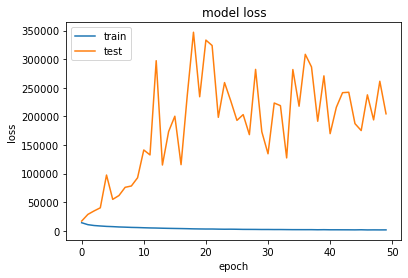

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
print(f'Train rmse: {mean_squared_error(y_train, train_preds, squared=False)}, r2: {r2_score(y_train, train_preds)}')
print(f'Test rmse: {mean_squared_error(y_test, test_preds, squared=False)}, r2: {r2_score(y_test, test_preds)}')

Train rmse: 205.2366216939113, r2: -1.1084158552013972
Test rmse: 833.7971550610515, r2: -8.82034066174324


In [68]:
X_train.reshape(X_train.shape[0], X_train.shape[1], 1).shape

(359825, 1525, 1)

In [103]:
def model_2():
    
    model = Sequential([
                        LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1],1)),
                        LSTM(50, return_sequences=True,activation='relu'),
                        Dropout(0.2),
                        LSTM(50, return_sequences=True,activation='relu'),
                        Dense(1)
                        ])

    model.compile(loss='mean_squared_error', optimizer=Adam(0.001))
    
    return model

In [101]:
import keras
import tensorflow as tf


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [98]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


In [ ]:
X_train_3d = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
model = model_2()
history = model.fit(X_train_3d, y_train, 
                    epochs=10, batch_size=32, validation_split = 0.2, verbose=2)

Epoch 1/10


In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
print(f'Train rmse: {mean_squared_error(y_train, train_preds, squared=False)}, r2: {r2_score(y_train, train_preds)}')
print(f'Test rmse: {mean_squared_error(y_test, test_preds, squared=False)}, r2: {r2_score(y_test, test_preds)}')

In [45]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(units=80, activation='relu'))
model.add(LSTM(units=80, activation='relu'))
# model.add(Dropout(0.2))
model.add(LSTM(units=80, activation='relu'))
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split = 0.2, verbose=2)

Epoch 1/10


ValueError: in user code:

    C:\Users\IsmailKaraman\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\IsmailKaraman\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\IsmailKaraman\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\IsmailKaraman\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\IsmailKaraman\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\IsmailKaraman\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\IsmailKaraman\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\IsmailKaraman\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\IsmailKaraman\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_9 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1525)


In [ ]:
order_df.shape

### model 2 - use other features

In [ ]:
# time series split
ts_cv = TimeSeriesSplit(
         n_splits=5,  #Number of splits used
         gap=0,  #No time needed between sets
         max_train_size=None, #Auto train sample size 
         test_size=None, #Auto test sample size)
    
all_splits = list(ts_cv.split(X, y))

In [ ]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [ ]:
gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
    ),
    HistGradientBoostingRegressor(
        categorical_features=range(2),
    ),
)

In [ ]:
evaluate(gbrt_pipeline, X, y, cv=ts_cv)

In [ ]:
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

In [ ]:
evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

### sin and cos transformer

In [ ]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
seasons_df = pd.DataFrame(
    np.arange(26).reshape(-1, 1),
    columns=["seasons"],
)
seasons_df["seasons_sin"] = sin_transformer(4).fit_transform(seasons_df)["seasons"]
seasons_df["seasons_cos"] = cos_transformer(4).fit_transform(seasons_df)["seasons"]
seasons_df.plot(x="seasons")_ = plt.title("Trigonometric encoding for the 'seasons' feature")

In [ ]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("seasons_sin", sin_transformer(4), ["seasons"]),
        ("seasons_cos", cos_transformer(4), ["seasons"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas),
)

In [ ]:
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

In [ ]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [ ]:
ols regression

# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

#### day difference between last order

In [ ]:
material_order_dates = df.groupby(['customer_num','order_num', 'material_num'])['order_date'].min().reset_index()
material_order_dates['shifted_date'] = material_order_dates.groupby(['customer_num','order_num', 'material_num'])['order_date'].diff()

#### last 1,2,3,5,7,10 orders

In [ ]:
order_amounts = df.groupby(['customer_num', 'material_num','order_num'])['order_amount'].sum().reset_index()
for period in [1,2,3,5,7,10]:
    col_name = 'last_' + str(period) + '_period_sum'
    order_amounts['rolling_sum'] = order_amounts.groupby(['customer_num', 'material_num'])['order_amount'] \
    .rolling(period, min_periods=period).sum().values
    
    order_amounts[col_name] = order_amounts.groupby(['customer_num', 'material_num'])['rolling_sum'].shift(1)

In [ ]:
order_amounts.isna().sum()/order_amounts.shape[0]

In [ ]:
df = pd.merge(df, order_amounts.drop(['order_amount', 'rolling_sum'], axis=1), on=['customer_num', 'material_num', 'order_num'])

### order_item numbers in an order

In [ ]:
item_counts = df.groupby(['order_num'])['order_item'].count().reset_index()
item_counts.columns = ['order_num', 'num_order_item']
df = pd.merge(df, item_counts, on=['order_num'], how='left')

#### last period averages

In [ ]:
df['last_2_period_avg'] = df['last_2_period_sum']/2
df['last_3_period_avg'] = df['last_3_period_sum']/3
df['last_5_period_avg'] = df['last_5_period_sum']/5
df['last_7_period_avg'] = df['last_7_period_sum']/7
df['last_10_period_avg'] = df['last_10_period_sum']/10

In [ ]:
weekly_resample = df.rolling('7D')
aggregated_df = weekly_resample.agg(['min', 'mean', 'max', 'std'])
aggregated_df.columns = ['_'.join(col).strip() + '_week' for col in 
                         aggregated_df.columns.values]

In [ ]:
order_df.sort_values(by=['order_date','order_num'], inplace=True)

In [ ]:
for i in range(len(order_df)):
    if order_df.order_num[i] > order_df.order_num[i+1]:
        print(i)

In [ ]:
order_df.head()

In [ ]:
from statsmodels.tsa.stattools import adfuller
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
adf_result = adfuller(order_summary)
print(adf_result)

### mean encoding for customer and product ??? or did we include that feature

In [ ]:
item_target_enc_na = .3343 # default na replacement
# Expanding Mean
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id')['target'].cumcount()

all_data['item_target_enc'] = cumsum/cumcnt
all_data['item_target_enc'].fillna(item_target_enc_na,inplace=True)
corr = np.corrcoef(all_data['target'].values, all_data['item_target_enc'])[0][1]
print(corr)

In [ ]:
sadece difference üzerinden featurelar bul

    - past data based model
        - convert sales to daily basis
        - geçmiş 10/20/30/40/50/60/90 gün verisi

## modelling

### lightgbm

In [ ]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

In [ ]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

In [ ]:
cat_features = ['shop_id', 'city', 'item_category_id', 'category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)      

preds = lgb_model.predict(X_test).clip(0,20)

In [ ]:
# prediction graph for different models

#Create teh predicted values:
naive_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[test_0])
one_hot_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[test_0])
cyclic_cossin_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(X.iloc[test_0])
cyclic_spline_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(X.iloc[test_0])
#Change "_0" with"_1", "_2", "_3" and "_4" for remaining splits
#Build the graph:
last_days = slice(-100, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by linear models")
ax.plot(
    y.iloc[test_0].values[last_days], #Change "_0" with 1,2,3 and 4
    "x-",
    alpha=0.2,
    label="Actual absenteeism in hours ",
    color="black",
)
ax.plot(
    naive_linear_predictions[last_days], 
    "x-", 
    label="Ordinal time features"
)
ax.plot(
    cyclic_cossin_linear_predictions[last_days],
    "x-",
    label="Trigonometric time features",
)
ax.plot(
    cyclic_spline_linear_predictions[last_days],
    "x-",
    label="Spline-based time features",
)
ax.plot(
    one_hot_linear_predictions[last_days],
    "x-",
    label="One-hot time features",
)
_ = ax.legend()

In [ ]:
# scatter plot

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    cyclic_cossin_linear_predictions,
    cyclic_spline_linear_predictions,
    one_hot_linear_predictions,
]
labels = [
    "cyclic_cossin_linear_predictions",
    "Splines + polynomial kernel",
    "Gradient Boosted Trees",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 0.125], [0, 0.125], "--", label="Perfect model")
    ax.set(
           xlim=(0, 0.125),
           ylim=(0, 0.125),
           xlabel="True absenteeism",
           ylabel="Predicted absenteeism",
    )
    ax.legend()
#Change "test_0" with _1, _2, _3 or _4 to obtain graphical visualisations for the other splits.

In [ ]:
# modeling non-linear features 1

cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_spline_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

In [ ]:
# modeling non-linear features 2
one_hot_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),         
            ("one_hot_time", one_hot_encoder, ["month_of_absence", "day_of_the_week"]),
        ],
        remainder="passthrough",
    ),
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(one_hot_poly_pipeline, X, y, cv=ts_cv)

In [ ]:
# creating dataframe for all customers, all materials and all dates

unq_materials = pd.DataFrame(order_df['material_num'].unique(), columns=['material_num'])
unq_materials['key'] = 1
unq_customers = pd.DataFrame(order_df['customer_num'].unique(), columns=['customer_num'])
unq_customers['key'] = 1
dates = pd.DataFrame(pd.date_range(start=raw_df['order_date'].min(), end=raw_df['order_date'].max()), columns=['order_date'])
dates['key'] = 1
all_data = pd.merge(dates, unq_customers, on=['key'])
all_data = pd.merge(all_data, unq_materials, on=['key']).drop('key', axis=1)